# Twitter7 (SNAP)


- Project-root discovery (find folder containing `src/`)
- `from src.core.config import SETTINGS`
- Dataset path as `Path(SETTINGS.DATA_ROOT) / "<dataset-folder>"`
- Streaming-friendly stats for large files

## Dataset (Twitter7 / SNAP)
Kaggle package: `wolfram77/graphs-snap-twitter7`.

Core files commonly included in this Kaggle dataset:
- `twitter7.mtx` (Matrix Market sparse adjacency; directed graph)
- `twitter7_celebrity_id.mtx` (celebrity id mapping/subset; Matrix Market)
- `twitter7_created_at.txt` (timestamps; text)
- `twitter7_description.txt` (text metadata; text)

> This notebook is designed to compute **sanity checks and descriptive stats**
> without loading everything into memory.


## 1. Environment Setup
This section imports the libraries used throughout the notebook and sets display defaults.


In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)


## 2. Project Root + Dataset Paths

1. Walk upward until we find the project root (a folder containing `src/`)
2. Add that root to `sys.path`
3. Load the project configuration via `from src.core.config import SETTINGS`
4. Define `DATASET_DIR = Path(SETTINGS.DATA_ROOT) / "twitter7"`

**What you should see:** the printed project root path and an existing dataset directory.

In [2]:
# Walk upwards until we find a folder that contains "src/"
p = Path.cwd().resolve()
while p != p.parent and not (p / "src").exists():
    p = p.parent

if not (p / "src").exists():
    raise RuntimeError("Could not find project root (folder containing 'src').")

sys.path.insert(0, str(p))

print("Project root:", p)
print("Has src?:", (p / "src").exists())

from src.core.config import SETTINGS

# Folder name under SETTINGS.DATA_ROOT
DATASET_DIR = Path(SETTINGS.DATA_ROOT) / "twitter7"
DATASET_DIR


Project root: /mnt/c/Users/rescic/PycharmProjects/dezinfo-datasets
Has src?: True


PosixPath('/home/rescic/dezinfo_data/twitter7')

### 2.1 File discovery + expected core files

We list the files that are present in `DATASET_DIR` and then check for a small set of **expected core files**.

 Kaggle bundles sometimes include extra files; this makes it obvious what you have locally and what might be missing.

In [3]:
# List what is actually present (useful if Kaggle adds extra metadata files)
present_files = sorted([x.name for x in DATASET_DIR.glob("*") if x.is_file()])
present_files[:50], len(present_files)


(['graphs-snap-twitter7.zip',
  'twitter7.mtx',
  'twitter7_celebrity_id.mtx',
  'twitter7_created_at.txt',
  'twitter7_description.txt',
  'twitter7_favourites_count.mtx',
  'twitter7_followers_count.mtx',
  'twitter7_following.txt',
  'twitter7_friends_count.mtx',
  'twitter7_location.txt',
  'twitter7_name.txt',
  'twitter7_nodeid.mtx',
  'twitter7_notifications.txt',
  'twitter7_profile_background_color.txt',
  'twitter7_profile_background_image_url.txt',
  'twitter7_profile_background_tile.txt',
  'twitter7_profile_image_url.txt',
  'twitter7_profile_link_color.txt',
  'twitter7_profile_sidebar_border_color.txt',
  'twitter7_profile_sidebar_fill_color.txt',
  'twitter7_profile_text_color.txt',
  'twitter7_protected.txt',
  'twitter7_screen_name.txt',
  'twitter7_statuses_count.mtx',
  'twitter7_time_zone.txt',
  'twitter7_url.txt',
  'twitter7_utc_offset.txt',
  'twitter7_verified.txt'],
 28)

In [4]:
FILES = {
    "graph_mtx": "twitter7.mtx",
    "celebrity_id_mtx": "twitter7_celebrity_id.mtx",
    "created_at": "twitter7_created_at.txt",
    "description": "twitter7_description.txt",
}

paths = {k: (DATASET_DIR / v) for k, v in FILES.items()}
missing = [k for k, path in paths.items() if not path.exists()]
missing


[]

## 3. MatrixMarket (.mtx) Helpers

Twitter7 uses MatrixMarket files, but **not all `.mtx` files have the same format**:

- `twitter7.mtx` is typically **coordinate** format (edges as row/col pairs)
- `twitter7_celebrity_id.mtx` is **array** format (a vector of values)

This section defines helpers to:
- read MatrixMarket header information
- preview the first few data rows
- stream edges for large coordinate graphs
- read small array vectors safely

We use lightweight parsing to avoid loading the full matrix into memory.


In [9]:
def mtx_info(path: Path) -> dict:
    """
    Parse MatrixMarket header and size line.

    Supports:
      - coordinate: size line has 3 ints (nrows ncols nnz)
      - array:      size line has 2 ints (nrows ncols)
    """
    with open(path, "rt", encoding="utf-8", errors="replace") as f:
        banner = f.readline().strip()
        if not banner.startswith("%%MatrixMarket"):
            raise ValueError(f"Not a MatrixMarket file: {path} (first line: {banner!r})")

        parts = banner.split()
        _, _, fmt, field, symmetry = parts[:5]

        # Skip comment lines
        line = f.readline()
        while line and line.lstrip().startswith("%"):
            line = f.readline()

        size_parts = line.strip().split()

        if fmt == "coordinate":
            nrows, ncols, nnz = map(int, size_parts[:3])
            return {"format": fmt, "field": field, "symmetry": symmetry, "nrows": nrows, "ncols": ncols, "nnz": nnz}

        if fmt == "array":
            nrows, ncols = map(int, size_parts[:2])
            return {"format": fmt, "field": field, "symmetry": symmetry, "nrows": nrows, "ncols": ncols, "nnz": nrows * ncols}

        raise ValueError(f"Unsupported MatrixMarket format '{fmt}' in {path}")


def read_mtx_head_edges(path: Path, nrows: int = 5) -> pd.DataFrame:
    """Read the first `nrows` edge lines after the MatrixMarket header."""
    with open(path, "rt", encoding="utf-8", errors="replace") as f:
        line = f.readline()
        while line and line.lstrip().startswith("%"):
            line = f.readline()
        _ = line  # size line
        rows = []
        for _ in range(nrows):
            l = f.readline()
            if not l:
                break
            rows.append(l.strip().split())

    df = pd.DataFrame(rows)
    if df.empty:
        return pd.DataFrame(columns=["src", "dst"])

    # 2 cols (pattern) or 3 cols (with value)
    df = df.iloc[:, :3] if df.shape[1] >= 3 else df.iloc[:, :2]
    df.columns = ["src", "dst"] + (["val"] if df.shape[1] == 3 else [])
    return df


def stream_mtx_stats(path: Path, chunksize_lines: int = 500_000) -> dict:
    """Streaming stats for MatrixMarket adjacency (may take time on huge graphs)."""
    from collections import Counter

    info = mtx_header_info(path)
    edges = 0
    self_loops = 0
    out_deg = Counter()
    in_deg = Counter()
    nodes = set()

    def process_lines(lines):
        nonlocal edges, self_loops
        for l in lines:
            l = l.strip()
            if not l:
                continue
            parts = l.split()
            if len(parts) < 2:
                continue
            try:
                src = int(parts[0])
                dst = int(parts[1])
            except ValueError:
                continue

            edges += 1
            if src == dst:
                self_loops += 1
            out_deg[src] += 1
            in_deg[dst] += 1
            nodes.add(src)
            nodes.add(dst)

    with open(path, "rt", encoding="utf-8", errors="replace") as f:
        line = f.readline()
        while line and line.lstrip().startswith("%"):
            line = f.readline()
        _ = line  # size line

        buf = []
        for line in f:
            buf.append(line)
            if len(buf) >= chunksize_lines:
                process_lines(buf)
                buf = []
        if buf:
            process_lines(buf)

    n_nodes = len(nodes)
    return {
        **info,
        "edges_streamed": edges,
        "unique_nodes_seen": n_nodes,
        "self_loops": self_loops,
        "avg_out_degree_seen": (edges / n_nodes) if n_nodes else float("nan"),
        "avg_in_degree_seen": (edges / n_nodes) if n_nodes else float("nan"),
        "max_out_degree": max(out_deg.values()) if out_deg else 0,
        "max_in_degree": max(in_deg.values()) if in_deg else 0,
    }

def read_mtx_array_vector(path: Path, dtype="int64") -> pd.Series:
    info = mtx_info(path)
    if info["format"] != "array":
        raise ValueError(f"Expected array format, got {info['format']}")
    if not (info["nrows"] == 1 or info["ncols"] == 1):
        raise ValueError(f"Expected vector shape, got {info['nrows']}x{info['ncols']}")

    data = []
    with open(path, "rt", encoding="utf-8", errors="replace") as f:
        _ = f.readline()  # banner
        line = f.readline()
        while line and line.lstrip().startswith("%"):
            line = f.readline()
        _ = line  # size line
        for line in f:
            s = line.strip()
            if not s or s.startswith("%"):
                continue
            data.append(s.split()[0])

    return pd.to_numeric(pd.Series(data), errors="coerce").dropna().astype(dtype)


## 4. Quick sanity checks (headers + first edges)

Before doing any heavy computation, we confirm:
- the MatrixMarket **format** (`coordinate` vs `array`)
- the reported dimensions / nnz
- a tiny sample of data rows

**Why this exists:** it prevents wasted time debugging downstream errors caused by format mismatches.

In [8]:
p = paths["celebrity_id_mtx"]
with open(p, "rt", encoding="utf-8", errors="replace") as f:
    for i in range(10):
        print(i+1, repr(f.readline()))

1 '%%MatrixMarket matrix array real general\n'
2 '%-------------------------------------------------------------------------------\n'
3 '% SuiteSparse Matrix Collection, Tim Davis\n'
4 '% https://sparse.tamu.edu/SNAP/twitter7\n'
5 '% name: SNAP/twitter7 : celebrity_id matrix\n'
6 '%-------------------------------------------------------------------------------\n'
7 '6499 1\n'
8 '12\n'
9 '13\n'
10 '15\n'


In [10]:
# Graph adjacency is true MatrixMarket
p = paths["graph_mtx"]
print("== graph_mtx ==")
info = mtx_info(p)
print(info)
display(read_mtx_head_edges(p, nrows=5))

# celebrity_id_mtx is NOT standard MM in this dataset; read as whitespace table
if paths["celebrity_id_mtx"].exists():
    celeb_ids = read_mtx_array_vector(paths["celebrity_id_mtx"])
    print("celebrity_id vector length:", len(celeb_ids))
    print("head:", celeb_ids.head(10).to_list())


== graph_mtx ==
{'format': 'coordinate', 'field': 'pattern', 'symmetry': 'general', 'nrows': 41652230, 'ncols': 41652230, 'nnz': 1468365182}


,src,dst
0,2,1
1,3,1
2,4,1
3,5,1
4,6,1


celebrity_id vector length: 6499
head: [12, 13, 15, 20, 53, 107, 291, 448, 572, 586]


## 5. Graph stats (streaming)

We compute basic descriptive statistics for the main graph (`twitter7.mtx`) **without loading the full graph**.

Computed metrics:
- edges streamed (should match `nnz` for coordinate graphs)
- unique nodes encountered
- self-loops
- max in-degree / out-degree (from streamed counters)

**Note:** tracking all unique nodes uses a Python `set` which can still be large - its meant as a helper if one would want to explore this aspect.

In [ ]:
graph_stats = stream_mtx_stats(paths["graph_mtx"], chunksize_lines=250_000) if paths["graph_mtx"].exists() else {}
graph_stats


## 6. created_at timestamps (streaming counts)

`twitter7_created_at.txt` contains timestamps for users/posts (format can vary by release).

This section:
- previews a few lines
- streams the file in chunks
- auto-detects whether timestamps are **epoch seconds** or **datetime strings**
- aggregates counts per day (UTC)

**Output:** a time series you can use to spot spikes, gaps, or unexpected ranges.


In [13]:
def read_head_text(path: Path, n: int = 5):
    with open(path, "rt", encoding="utf-8", errors="replace") as f:
        return [f.readline().rstrip("\n") for _ in range(n)]

if paths["created_at"].exists():
    read_head_text(paths["created_at"], 5)


In [15]:
def stream_created_at_counts(path: Path, chunksize: int = 1_000_000, bucket: str = "D") -> pd.Series:
    counts = None

    for chunk in pd.read_csv(path, header=None, chunksize=chunksize, engine="python"):
        s = chunk.iloc[:, 0].astype(str).str.strip()
        s = s[s != ""]

        ts_num = pd.to_numeric(s, errors="coerce")

        # Case 1: looks like epoch seconds
        if ts_num.notna().mean() > 0.9:
            dt = pd.to_datetime(ts_num.dropna().astype("int64"), unit="s", utc=True)
        else:
            # Case 2: formatted datetime strings
            dt = pd.to_datetime(s, utc=True, errors="coerce", format="mixed")

        dt = dt.dropna()
        if dt.empty:
            continue

        if bucket == "D":
            b = dt.dt.floor("1D")
        elif bucket == "H":
            b = dt.dt.floor("1H")
        else:
            b = dt.dt.floor(bucket)

        c = b.value_counts()
        counts = c if counts is None else counts.add(c, fill_value=0)

    if counts is None:
        return pd.Series(dtype="float64")
    return counts.sort_index()


created_counts_day = stream_created_at_counts(paths["created_at"], chunksize=1_000_000, bucket="D") if paths["created_at"].exists() else pd.Series(dtype="float64")
created_counts_day.head(), created_counts_day.shape


(0
 2006-03-21 00:00:00+00:00    4
 2006-04-01 00:00:00+00:00    1
 2006-04-14 00:00:00+00:00    1
 2006-05-20 00:00:00+00:00    1
 2006-07-11 00:00:00+00:00    1
 Name: count, dtype: int64,
 (899,))

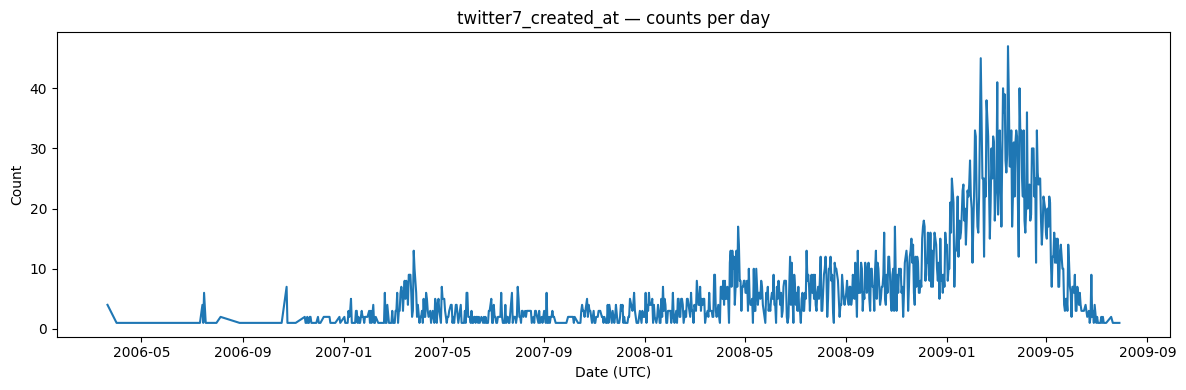

In [16]:
if not created_counts_day.empty:
    plt.figure(figsize=(12, 4))
    plt.plot(created_counts_day.index, created_counts_day.values)
    plt.title("twitter7_created_at — counts per day")
    plt.xlabel("Date (UTC)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


## 7. description file (preview + line-length stats)

The description file is treated as **line-based text** (format varies).

We:
- preview the first few lines
- compute simple line-length statistics (avg/max)

**Why this exists:** it gives a quick sense of whether the file contains short labels vs long descriptions, and whether it looks well-formed.
"""

In [20]:
if paths["description"].exists():
    read_head_text(paths["description"], 5)


In [21]:
def stream_line_length_stats(path: Path) -> dict:
    n = 0
    total_len = 0
    max_len = 0

    with open(path, "rt", encoding="utf-8", errors="replace") as f:
        for line in f:
            n += 1
            L = len(line.rstrip("\n"))
            total_len += L
            if L > max_len:
                max_len = L

    return {"lines": n, "avg_len": (total_len / n) if n else float("nan"), "max_len": max_len}

desc_stats = stream_line_length_stats(paths["description"]) if paths["description"].exists() else {}
desc_stats


{'lines': 6499, 'avg_len': 78.78519772272658, 'max_len': 160}

## 8. NetworkX sampling + SCCs
Running graph algorithms on the full Twitter7 graph is usually infeasible in a notebook.

Here we:
- sample a fixed number of edges from `twitter7.mtx`
- build a small directed graph with NetworkX
- compute SCC sizes for qualitative insight

**Important:** results reflect the sample, not the full graph.


In [22]:
import networkx as nx

def sample_mtx_edges(path: Path, n_edges: int = 200_000, seed: int = 7) -> pd.DataFrame:
    rows = []
    with open(path, "rt", encoding="utf-8", errors="replace") as f:
        line = f.readline()
        while line and line.lstrip().startswith("%"):
            line = f.readline()
        _ = line  # size line

        for line in f:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            try:
                src = int(parts[0]); dst = int(parts[1])
            except ValueError:
                continue
            rows.append((src, dst))
            if len(rows) >= n_edges:
                break

    df = pd.DataFrame(rows, columns=["src", "dst"])
    return df.sample(frac=1.0, random_state=seed).reset_index(drop=True)


if paths["graph_mtx"].exists():
    sample = sample_mtx_edges(paths["graph_mtx"], n_edges=200_000, seed=7)
    G = nx.from_pandas_edgelist(sample, source="src", target="dst", create_using=nx.DiGraph)

    sccs = list(nx.strongly_connected_components(G))
    sizes = sorted((len(c) for c in sccs), reverse=True)

    summary = {
        "sample_edges": G.number_of_edges(),
        "sample_nodes": G.number_of_nodes(),
        "num_sccs": len(sccs),
        "largest_scc_size": sizes[0] if sizes else 0,
        "top10_scc_sizes": sizes[:10],
    }
    display(summary)   # or: print(summary)
else:
    print("graph_mtx not found at:", paths["graph_mtx"])

{'sample_edges': 200000,
 'sample_nodes': 120494,
 'num_sccs': 119981,
 'largest_scc_size': 465,
 'top10_scc_sizes': [465, 7, 5, 4, 3, 3, 3, 3, 3, 3]}